In [1]:
## first block of code is just importing the requirements of the project

import sys 
import os
import h5py
import pickle
from matplotlib import pyplot as plt

from scipy import ndimage as ndi
from scipy import stats as sstats

import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from random import shuffle
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
import random
import mahotas 
from sklearn.preprocessing import normalize
from PIL import Image
import imutils
import logging

from glob import glob

In [2]:
# this block of code is importing all the various parts of the project from their respective modules
from icon_util import *
from methods import *
from aberrations import *

In [3]:
image_set_name = "icon10"

# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
#images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])

# alternatively, h5py objects can be used like numpy arrays without loading the whole dataset into memory:
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])
# here, images[0] will be again returned as a numpy array and can eg. be viewed with matplotlib using
images = [np.transpose(i) if i.shape[0] == 3 else i for i in images[:10]]
print(len(images))

method_classes = [zernike_method, orb_method, neural_method, sift_method, contour_method]
#method_classes = [orb_method]

10


In [4]:
# uncomment this if you want to generate the databases
generate_databases(images, method_classes, image_set_name)
methods = load_databases(method_classes, image_set_name)
print("Loading Completed")
#####################
# main loop 	#####
#####################
results = run(methods, images, aberrations[:1])
log_num = len(glob("Logs/*")) + 1
results.to_csv ('Logs/results_'+str(log_num)+'.csv', index = None, header=True)
print("Done")

0
0
0
0
0
Loading Completed
0


In [5]:
# Load all the logs into a single dataframe for processing
log_files = glob("Logs/*") # these are the logs that we're loading
print(log_files)
joined_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(joined_logs)

['Logs\\results_1.csv', 'Logs\\results_10.csv', 'Logs\\results_11.csv', 'Logs\\results_12.csv', 'Logs\\results_13.csv', 'Logs\\results_14.csv', 'Logs\\results_15.csv', 'Logs\\results_2.csv', 'Logs\\results_3.csv', 'Logs\\results_4.csv', 'Logs\\results_5.csv', 'Logs\\results_6.csv', 'Logs\\results_7.csv', 'Logs\\results_8.csv', 'Logs\\results_9.csv']
   aberration           method       score  rank      time
0       ab_id   zernike_method  100.000000     1  0.011890
1       ab_id       orb_method  100.000000     1  0.027742
2       ab_id    neural_method   99.999994     1  0.153750
3       ab_id      sift_method  100.000000     1  0.076091
4       ab_id  combined_method  100.000000     1  0.000300
..        ...              ...         ...   ...       ...
55      ab_id       orb_method  100.000000     1  0.006295
56      ab_id    neural_method   99.999994     1  0.119658
57      ab_id      sift_method  100.000000     1  0.045389
58      ab_id   contour_method  100.000000     1  0.060508

Ranking


Text(0.5, 1.0, 'Combined')

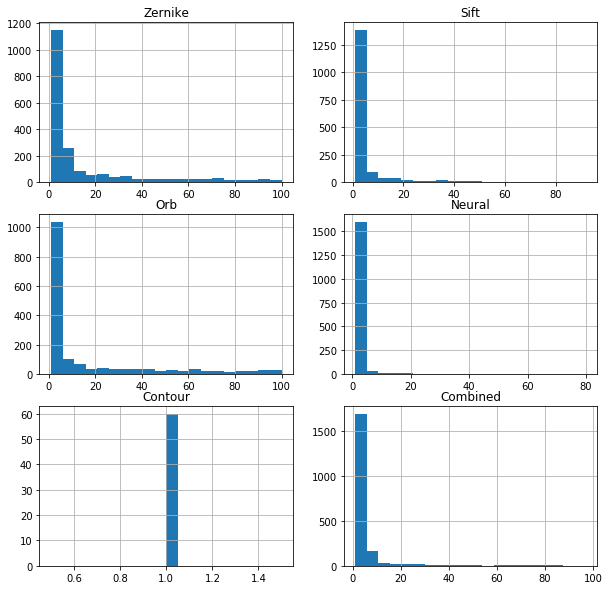

In [6]:
print("Ranking")
fig, axes = plt.subplots(nrows=3, ncols=2)
joined_logs[joined_logs['method']=='zernike_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
joined_logs[joined_logs['method']=='sift_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Sift')
joined_logs[joined_logs['method']=='orb_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
joined_logs[joined_logs['method']=='neural_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
joined_logs[joined_logs['method']=='contour_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,0])
axes[2,0].set_title('Contour')
joined_logs[joined_logs['method']=='combined_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
axes[2,1].set_title('Combined')

Timing


[(0, 0.2)]

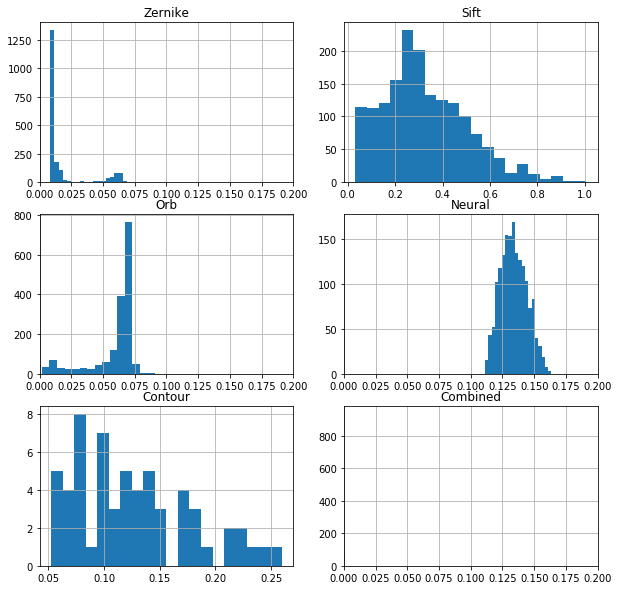

In [7]:
print("Timing")
fig, axes = plt.subplots(nrows=3, ncols=2)
joined_logs[joined_logs['method']=='zernike_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
axes[0,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='sift_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Sift')
#axes[0,1].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='orb_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
axes[1,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='neural_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
axes[1,1].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='contour_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[2,0])
axes[2,0].set_title('Contour')
#axes[2,0].set(xlim=(0,0.2))
joined_logs[joined_logs['method']=='combined_method']['time'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
axes[2,1].set_title('Combined')
axes[2,1].set(xlim=(0,0.2))

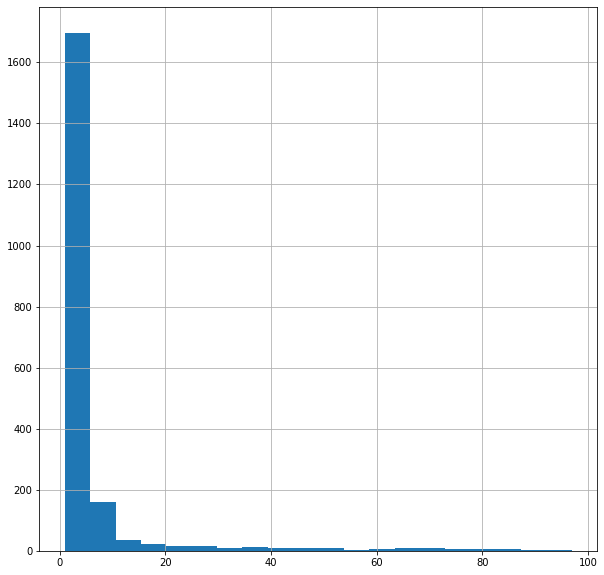

In [8]:
# joined_logs[joined_logs['method']=='neural_method']['rank'].plot.hist(bins=100)
# joined_logs.plot.kde()
# pd.plotting.andrews_curves(joined_logs['rank'], 'method')
# print(list('ABCD'))

#joined_logs.groupby('method').plot.hist()
#joined_logs[['method', 'rank']].hist(by='method')
#joined_logs[['method','rank','aberration']].groupby('method').plot.hist(bins=100, label='method')
#joined_logs.groupby('method').plot(kind='hist', subplots=True, figsize=(6,6))
#joined_logs[joined_logs['method']=='zernike_method'].hist(bins=20, figsize=(20,20))
#joined_logs[(joined_logs['method']=='zernike_method') & (joined_logs['aberration']=='ab_id')]
joined_logs[joined_logs['method']=='combined_method']['rank'].hist(bins=20, figsize=(10,10))

In [9]:
# #####################
# # main loop 	#####
# #####################

# # load image  and apply random mutation 
# for m in range(100,200):
# 	image_index = m
# 	Data = prep_img(images[image_index])
# 	Data, mutation = ab_two_line_circle( Data)

# 	# define fractions along line segment to be used 
# 	fractions = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

# 	# create queries from the image 
# 	contour_query, zernike_query = create_query( Data, fractions)

# 	# obtain results from ORB  
# 	orb_list = run_orb_image(Data, hash_orb)
# 	print("Orb score: ",orb_list[image_index]) 

# 	# obtain results from SIFT  
# 	sift_list = run_sift_image(Data, hash_sift)
# 	print("Sift score: ",sift_list[image_index]) 

# 	# obtain results from contour method and zernike method 
# 	zernike_list = test_zernike( zernike_query, hash_zernike )	
# 	print("Zernike score: ",zernike_list[image_index])
# 	contour_list = test_contour( contour_query, 0.002, fractions, hash_contour )
# 	print("Contour score: ",contour_list[image_index])

# 	# combine scores of each method and log the results, input the weights along with the results from each method  
# 	weights = [.25,.25,.25,.25]
# 	matched_list_v2 = test_combined(weights, contour_list, zernike_list, sift_list, orb_list)

# 	# create a log file of the results 
# 	log_results ( image_index, mutation, matched_list_v2, contour_list, zernike_list, sift_list, orb_list )

# 	# find the rank of the original image, just for checking purposes 	
# 	rank = 0
# 	for hit in matched_list_v2:
# 		rank += 1
# 		if hit[0] == image_index:
# 			print("Final ranking: ",rank,hit)
# 			break 

In [10]:
# ## plot query image and top 11 hits, just for checking purposes  
# plot_results(Data, matched_list_v2)

In [11]:
# ## load scores from log files
# success = []
# contour_score = []
# zernike_score = []
# sift_score = []
# orb_score = []
# image = []
# indices = []
# mutation = []
# contour_orig = []
# sift_orig = []

# # loop through image indices of existing queries 
# for fname in tqdm_notebook(os.listdir('.\Logs')):
# 	x1 = fname.find('_')+1
# 	x2 = fname.find('.')
# 	i = int(fname[x1:x2])
# 	indices.append(i)

# 	j = 0
# 	#open log file of query
# 	with open('C:/Users/kchad/Documents/LogoMatch/Logs/' + fname,"r") as myfile:
# 		for line in myfile:
# 			j += 1
# 			if j % 8 == 0:
# 				for k in range(0,result_len):
# 					mutation.append(line[11:])
# 			if j % 8 == 1:
# 				result_len = 0           
# 			#  line has the results 
# 			if j % 8 == 7:
# 				result = eval(line[13:])
# 				result_len = len(result)
# 				first_contour = result[0][1]
# 				first_zernike = result[0][2]
# 				first_sift = result[0][3]
# 				first_orb = result[0][4]
				
# 				# check if the given query result was the original image, 1 for correct, 0 for incorrect
# 				for elem in result:
# 					if elem[0] == i:
# 						success.append(1)
# 					else:
# 						success.append(0)
						
# 					# normalize the contour/zernike scores
# 					if first_contour > 0:                    
# 						contour_score.append( round(elem[1]/first_contour, 3) )
# 					else:
# 						contour_score.append(0)    
                        
# 					if first_zernike > 0:                         
# 						zernike_score.append( round(elem[2]/first_zernike, 3) )
# 					else:
# 						zernike_score.append(0)                        
# 					if first_sift > 0:
# 						sift_score.append( round(elem[3]/first_sift, 3) )
# 					else:
# 						sift_score.append(0)
                        
# 					if first_orb > 0:
# 						orb_score.append( round(elem[4]/first_orb, 3) )
# 					else:
# 						orb_score.append(0)                        

# 					image.append(i)
# 					contour_orig.append(elem[1])     
# 					sift_orig.append(elem[3]) 

# ### save all the scores in a csv file

# input_score = np.array(list(zip(contour_score,zernike_score,sift_score,orb_score,image,success,mutation,contour_orig,sift_orig)))
# input_score = pd.DataFrame(input_score,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])
# print( input_score.head )
# input_score.to_csv (r'input_scores.csv', index = None, header=True)

In [12]:
# ###### logsitic regression for weights of 4 methods
# numbers = [i for i in range(100,200)]

# ### randomly create training and test set
# random.shuffle(numbers)
# training = numbers[0:60]
# testing = numbers[60:100]

# ### search for a particular mutation
# mutation_string = 'ab_line_circle'
# print(mutation_string)

# ### set threshold for contour and sift, set accuracy cutoff (top 10 or top 20)
# contour_thresh = 0
# sift_thresh = 0
# rank_cutoff = 20

# ### create training set, filter for mutation name and thresholds 
# input_score_mutation = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(training)) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
# input_score_mutation = input_score_mutation.values

# ### create test data set, not used for training
# input_score_test = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(testing) ) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
# input_score_test = pd.DataFrame(input_score_test,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

# ### run logistic regression on training data
# clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(input_score_mutation[:,(0,1,2,3)], input_score_mutation[:,5])
# logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
# print('Logistic Weights')
# print(logistic_weights)

# ### use weights to calculate weighted score and rank on training set
# input_score_mutation = pd.DataFrame(input_score_mutation,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

# input_score_mutation["contour_score"] = input_score_mutation["contour_score"].astype(float)
# input_score_mutation["zernike_score"] = input_score_mutation["zernike_score"].astype(float)
# input_score_mutation["sift_score"] = input_score_mutation["sift_score"].astype(float)
# input_score_mutation["orb_score"] = input_score_mutation["orb_score"].astype(float)

# input_score_mutation["avg_score"] = .25*input_score_mutation["contour_score"] + .25*input_score_mutation["zernike_score"] + .25*input_score_mutation["sift_score"] + .25*input_score_mutation["orb_score"]
# input_score_mutation["weight_score"] = logistic_weights[0]*input_score_mutation["contour_score"] + logistic_weights[1]*input_score_mutation["zernike_score"] + logistic_weights[2]*input_score_mutation["sift_score"] + logistic_weights[3]*input_score_mutation["orb_score"]
# input_score_mutation['Avg_Rank'] = input_score_mutation.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
# input_score_mutation['Weight_Rank'] = input_score_mutation.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

# ### use weights to calculate weighted score and rank on test set
# input_score_test["contour_score"] = input_score_test["contour_score"].astype(float)
# input_score_test["zernike_score"] = input_score_test["zernike_score"].astype(float)
# input_score_test["sift_score"] = input_score_test["sift_score"].astype(float)
# input_score_test["orb_score"] = input_score_test["orb_score"].astype(float)

# input_score_test["avg_score"] = .25*input_score_test["contour_score"] + .25*input_score_test["zernike_score"] + .25*input_score_test["sift_score"] + .25*input_score_test["orb_score"]
# input_score_test["weight_score"] = logistic_weights[0]*input_score_test["contour_score"] + logistic_weights[1]*input_score_test["zernike_score"] + logistic_weights[2]*input_score_test["sift_score"] + logistic_weights[3]*input_score_test["orb_score"]
# input_score_test['Avg_Rank'] = input_score_test.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
# input_score_test['Weight_Rank'] = input_score_test.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

# ### check the rank of the original image, see if image was within the top 10 or top 20 search results
# successes = input_score_mutation[input_score_mutation["success"].astype(float) == 1]

# avg_rank = sum(successes['Avg_Rank'])/successes.shape[0]
# weight_rank = sum(successes['Weight_Rank'])/successes.shape[0]
# top10_avg_rank = len( successes[(successes['Avg_Rank'] <= rank_cutoff)] )
# top10_weight_rank = len( successes[(successes['Weight_Rank'] <= rank_cutoff)] )

# print('Training Accuracy')
# print((top10_avg_rank,top10_weight_rank))

# successes_t = input_score_test[input_score_test["success"].astype(float) == 1]

# avg_rank_t = sum(successes_t['Avg_Rank'])/successes_t.shape[0]
# weight_rank_t = sum(successes_t['Weight_Rank'])/successes_t.shape[0]
# top10_avg_rank_t = len( successes_t[(successes_t['Avg_Rank'] <= rank_cutoff)] )
# top10_weight_rank_t = len( successes_t[(successes_t['Weight_Rank'] <= rank_cutoff)] )

# print('Testing Accuracy')
# print((top10_avg_rank_t,top10_weight_rank_t))

# #input_score.to_csv(path_or_buf='./score_result_2.csv', sep=',',index = False)

In [13]:
# ### display an image
# image_index = 50
# Data = gray(images[image_index])
# Data, mutation = ab_random(Data, n = 9)

# imgplot = plt.imshow(Data, cmap=plt.cm.gray)
# plt.axis('off')
# plt.show()

In [14]:
testd = {}
print(testd)
print(testd.get(0, []))
print(testd)
print(testd.setdefault(0, []).append("heyy"))
print(testd)

{}
[]
{}
None
{0: ['heyy']}


In [15]:
df2 = pd.DataFrame({'a': ['one', 'one', 'two', 'three', 'two', 'one', 'six'], 'b': ['x', 'y', 'y', 'x', 'y', 'x', 'x'], 'c': np.random.randn(7)})
print(df2)

       a  b         c
0    one  x  0.609540
1    one  y -0.428223
2    two  y  0.513745
3  three  x  0.449127
4    two  y -2.083441
5    one  x -1.285363
6    six  x  0.082860


In [16]:
print(df2[df2['c'] > 0])

       a  b         c
0    one  x  0.609540
2    two  y  0.513745
3  three  x  0.449127
6    six  x  0.082860
